In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

Load parameters

In [2]:
# load search df
df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)

# load best parameters set from search dataframe
from utilities.analyze_inference import best_par_in_df
par = best_par_in_df(df)

Simulate stochastic model keeping trace of the clonal families

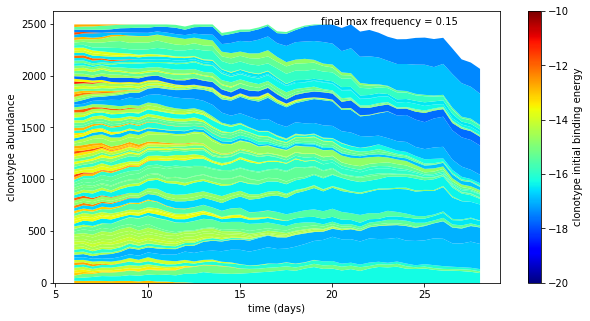

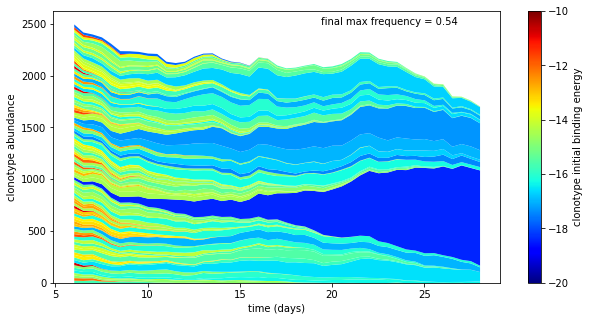

In [3]:
from utilities.clonotype_analysis import stoch_GC_clonotype_evo, plot_GC_ctype_evo

N_sims = 1000 # number of stochastic simulations
D_test = 1. # injected Ag dosage
T_test = 28 # number of days of evolution

sim_results = [] # list of simulation results

for n_seed in range(N_sims):
    # for reproducibility of the two examples 
    np.random.seed(n_seed)
    
    # perform a stochastic simulation
    # returns the evolution of the number of clones over time,
    # the initial binding energy of each clonotype family
    # the evolution of the frequency of the most abundant clonotype,
    # the list of time-points (in days) at which the results are collected
    ctype_evo_df, ctype_en, f_max, t_days = stoch_GC_clonotype_evo(par, D_test, T_test)
    
    # create a dictionary entry to append to the results.
    # it contains the evolution of the must abundant clonotype frequency
    df_entry = {f'fmax_t_{t_days[n]}' : fm for n, fm in enumerate(f_max)}
    # the initial binding energy of the highest affinity clonotype
    df_entry['best_founder_en'] = ctype_en.min()
    # the seed that produced the simulation
    df_entry['seed'] = n_seed
    # append the result to the result list
    sim_results.append(df_entry)
    
    # 
    if n_seed == 74:
        plot_GC_ctype_evo(ctype_evo_df, ctype_en, savename='figures/fig_3/low_clonal_dominance_example.pdf',
                          cmap_range=[-20,-10])
    if n_seed == 260:
        plot_GC_ctype_evo(ctype_evo_df, ctype_en, savename='figures/fig_3/high_clonal_dominance_example.pdf',
                          cmap_range=[-20,-10])
        
    
# create dataframe with the results
results_df = pd.DataFrame(sim_results)
results_df = results_df.set_index('seed')

# save simulation results in a pickle archive
with open('figures/fig_3/stoch_sim_results.pkl', 'wb') as f:
    pkl.dump(results_df, f)
    f.close()

In [4]:
with open('figures/fig_3/stoch_sim_results.pkl', 'rb') as f:
    results_df = pkl.load(f)
    f.close()

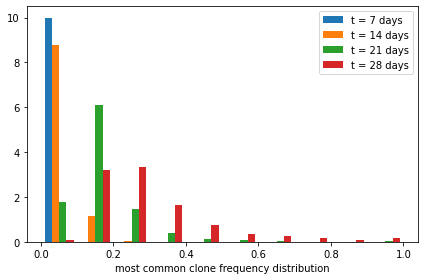

In [5]:
t_hist = [7., 14., 21., 28.]
bins = np.linspace(0,1,11)

freq_mat = results_df[[f'fmax_t_{th}' for th in t_hist]].to_numpy()

plt.hist(freq_mat, bins=bins, density=True, label = [f't = {int(th)} days' for th in t_hist])
plt.xlabel('most common clone frequency distribution')
plt.legend()
plt.tight_layout()
plt.savefig('figures/fig_3/freq_distribution.pdf')
plt.show()

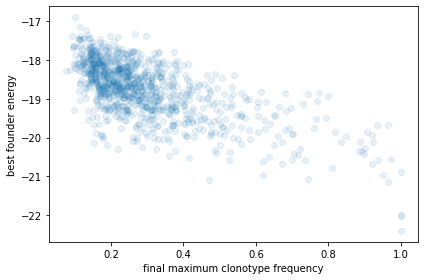

In [6]:
freq_final = results_df['fmax_t_28.0']
best_en = results_df['best_founder_en']
plt.scatter(freq_final, best_en, alpha=0.1)
plt.ylabel('best founder energy')
plt.xlabel('final maximum clonotype frequency')
plt.tight_layout()
plt.savefig('figures/fig_3/scatter_freq_vs_dominance.pdf')
plt.show()